# CHEKING HOW CHAGES IN THE ENVIRONMENT AFFECT NUTRIENTS UPTAKE

In [1]:
#Import necessary libraries
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model = cobra.io.read_sbml_model("../model/Mouse-GEM.xml")

https://identifiers.org/taxonomy/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [ ]:
#creating anearobic condition

anaerobic_model = model.copy()

# Blocking oxygen uptake (O2)
anaerobic_model.reactions.get_by_id("MAR09048").lower_bound = 0

# Blocking CO2 secretion
anaerobic_model.reactions.get_by_id("MAR09058").upper_bound = 0


In [ ]:
#-------Baseline anaerobic condition------
default_solution = anaerobic_model.optimize()
default_biomass = default_solution.objective_value

print(f"Anaerobic baseline biomass: {default_biomass:.4f}")


Anaerobic baseline biomass: 4.2628


In [ ]:
#-------Identifying uptake genes-------
uptake_reactions = [
    rxn for rxn in anaerobic_model.exchanges if rxn.lower_bound < 0
]

print(f"Number of uptake reactions tested: {len(uptake_reactions)}")


Number of uptake reactions tested: 1657


In [9]:
#------Blocking uptake reactions one by one------
import pandas as pd

uptake_effects = []

for rxn in uptake_reactions:
    
    # Save original bounds
    original_bounds = (rxn.lower_bound, rxn.upper_bound)
    
    # Block uptake
    rxn.lower_bound = 0
    
    # Re-run FBA
    solution = anaerobic_model.optimize()
    
    if solution.status == "optimal":
        biomass = solution.objective_value
    else:
        biomass = 0
    
    uptake_effects.append({
        "rxn": rxn.id,
        "biomass_flux": biomass
    })
    
    # Restore bounds
    rxn.lower_bound, rxn.upper_bound = original_bounds

data_ana = pd.DataFrame(uptake_effects)
data_ana.head()


,rxn,biomass_flux
0,MAR07108,4.262828
1,MAR07110,4.262828
2,MAR07112,4.262828
3,MAR07114,4.262828
4,MAR07116,4.262828


In [10]:
#Plotting the results
import plotly.express as px

fig = px.bar(
    data_ana,
    x="rxn",
    y="biomass_flux",
    template="none",
    title="Effect of blocking nutrient uptake under anaerobic conditions (Mouse-GEM)"
)

fig.add_shape(
    type="line",
    x0=-0.5,
    x1=len(data_ana.index) - 0.5,
    y0=default_biomass,
    y1=default_biomass,
    line=dict(color="red", dash="dash")
)

fig.show()


# Figure 1a: Distribution of reactions across compartments

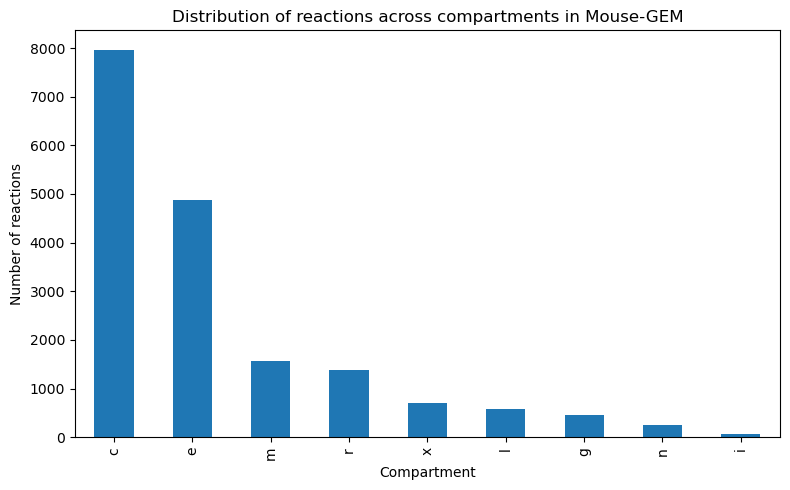

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Count reactions per compartment
reaction_compartments = []

for rxn in model.reactions:
    compartments = set(m.compartment for m in rxn.metabolites)
    for comp in compartments:
        reaction_compartments.append(comp)

reaction_compartment_counts = (
    pd.Series(reaction_compartments)
    .value_counts()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(8,5))
reaction_compartment_counts.plot(kind="bar")
plt.ylabel("Number of reactions")
plt.xlabel("Compartment")
plt.title("Distribution of reactions across compartments in Mouse-GEM")
plt.tight_layout()
plt.show()


# 1b : Distribution of metabolites across compartments

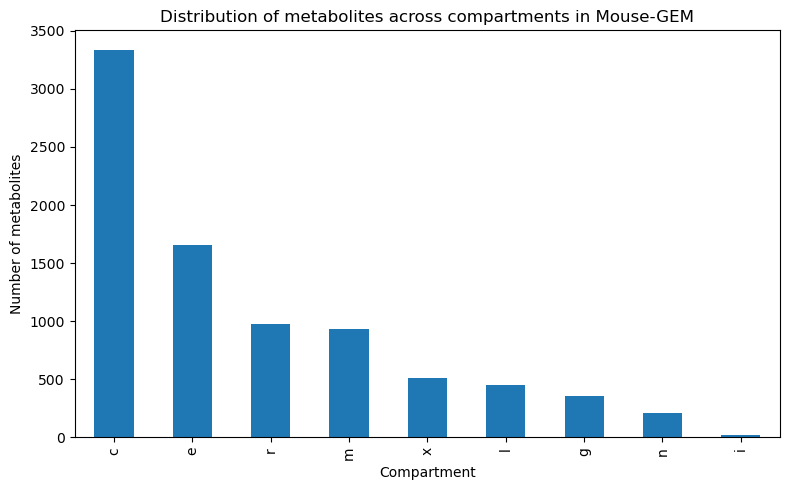

In [12]:
# Count metabolites per compartment
metabolite_compartment_counts = (
    pd.Series([met.compartment for met in model.metabolites])
    .value_counts()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(8,5))
metabolite_compartment_counts.plot(kind="bar")
plt.ylabel("Number of metabolites")
plt.xlabel("Compartment")
plt.title("Distribution of metabolites across compartments in Mouse-GEM")
plt.tight_layout()
plt.show()
